In [1]:
import h5py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#PCP EXTRACTED PROPERTIES FOR UNIPROT PROTEINS
json_path = "/content/drive/MyDrive/protein_props.json"
with open(json_path) as f:
  data = json.load(f)

okk = pd.read_json(json_path)
properties = okk.transpose()

druggable_data = "/content/drive/MyDrive/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "/content/drive/MyDrive/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

is_druggable = []
for i in properties.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties['is_druggable'] = is_druggable
properties['is_approved'] = approved_drugs

PCP_Properties = properties.copy()

index = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {}
for i in index:
  amino_acid_percent[i] = []
for j in PCP_Properties['Amino Acid Percent']:
  for ind in index:
    amino_acid_percent[ind].append(j[ind])
for okk in index:
  PCP_Properties = pd.concat([PCP_Properties, pd.Series(amino_acid_percent[okk], index = PCP_Properties.index, name = f"Amino Acid Percent {okk}")], axis = 1)

PCP_Properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_Properties['Molar Extinction Coefficient']], index = PCP_Properties.index)
PCP_Properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_Properties['Molar Extinction Coefficient']], index = PCP_Properties.index)

PCP_Properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_Properties['Secondary Structure']], index = PCP_Properties.index)
PCP_Properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_Properties['Secondary Structure']], index = PCP_Properties.index)
PCP_Properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_Properties['Secondary Structure']], index = PCP_Properties.index)

PCP_Properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_Properties['Sequence Length'] = PCP_Properties['Sequence Length'] .astype(int)
PCP_Properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_Properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

3345
2652


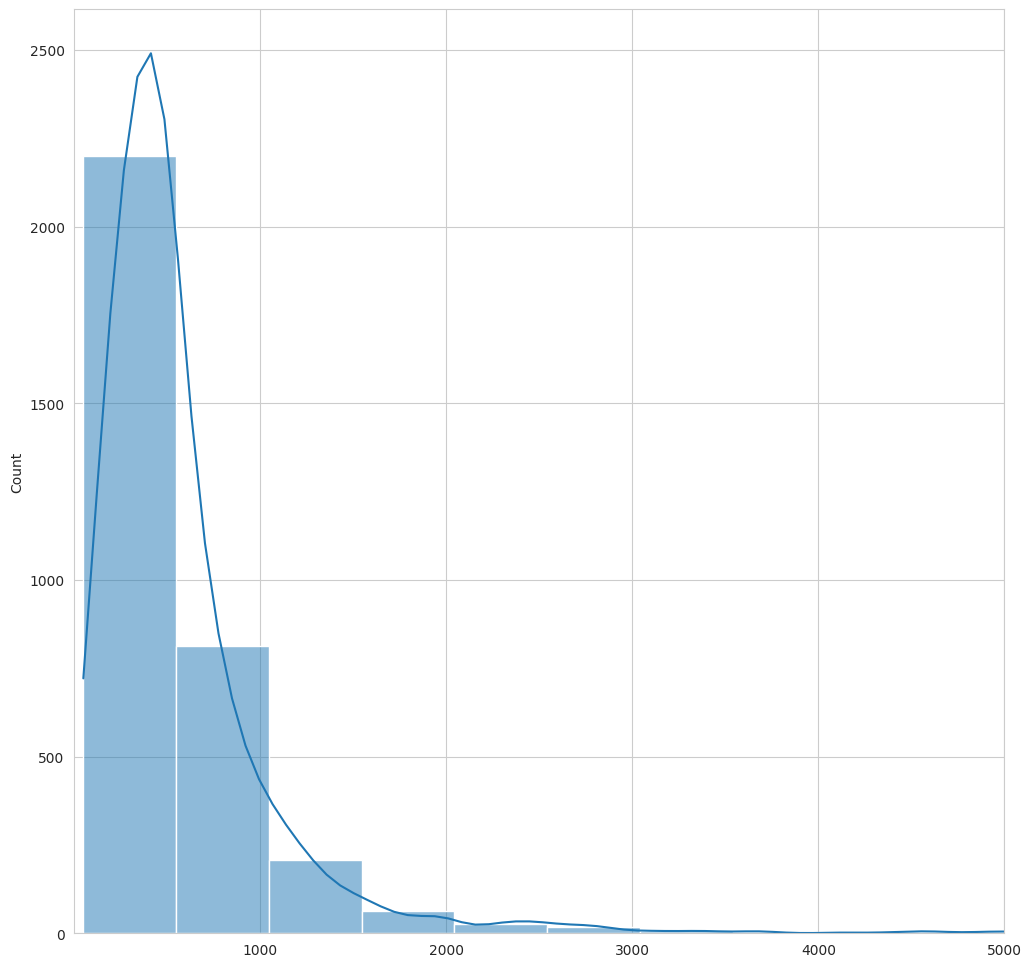

In [4]:
sequence = properties['Sequence']
non_druggable_sequence = properties[properties['is_druggable'] == 1]['Sequence']

length = []
for i in non_druggable_sequence:
  length.append(len(i))

fig,ax = plt.subplots(figsize = (12,12))
sns.histplot(length, kde = True, ax = ax, binwidth = 500)
ax.set_xlim(1,5000)
plt.show()

In [27]:
length = []
for i in sequence:
  length.append(len(i))
minimum = np.array(length).min()
maximum = np.array(length).max()

print(f"Maximum Length of Sequence {maximum}")
print(f"Minimum Length of Sequence {minimum}")

Maximum Length of Sequence 34350
Minimum Length of Sequence 2


In [56]:
def kmer(seq,seq_length,kmer_length=2):
    kmer_words = [seq[i:i+seq_length] for i in range(len(seq)-seq_length+1)]
    return ' '.join(kmer_words)

In [57]:
#NLP Technique : Kmers Tf- Idf Technique
from sklearn.feature_extraction.text import TfidfVectorizer

data = pd.DataFrame(sequence)
kmer_length = 2
data['kmer_sequence'] = data['Sequence'].apply(lambda x: kmer(x,kmer_length))

tfidfvector = TfidfVectorizer()
X = tfidfvector.fit_transform(data['kmer_sequence']).astype('float32')

feat_names = tfidfvector.get_feature_names_out()
df = pd.DataFrame(data=X.toarray(),
                       index=data.index,
                       columns=feat_names)

In [58]:
path = "/content/drive/MyDrive/BDDF_Research/tf_idf_data.csv"
df.to_csv(path)

In [41]:
#Using NLP Technique 2 : Word2Vec Gensim Model (Skip Gram Embeddings)
from gensim.models import Word2Vec

# Convert data to DataFrame
df = pd.DataFrame(sequence)

# K-mer Tokenization function
def kmer(sequence, k=2):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Apply k-mer tokenization
df['kmer_sequence'] = df['Sequence'].apply(lambda x: kmer(x, 2))

# Verify the generated k-mers
print(df['kmer_sequence'].head())

# Prepare sentences for Word2Vec
sentences = df['kmer_sequence'].tolist()

# Train Word2Vec model (using Skip-gram model here)
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1, workers=4)

# Get embeddings for each k-mer
kmer_embeddings = {kmer: word2vec_model.wv[kmer] for kmer in word2vec_model.wv.key_to_index}

# Example: Get the embedding for a specific k-mer
example_kmer = "MG"
if example_kmer in kmer_embeddings:
    print(f"Embedding for {example_kmer}: {kmer_embeddings[example_kmer]}")
else:
    print(f"{example_kmer} not found in vocabulary")

A0A087X1C5    [MG, GL, LE, EA, AL, LV, VP, PL, LA, AM, MI, I...
A0A0B4J2F0    [MF, FR, RR, RL, LT, TF, FA, AQ, QL, LL, LF, F...
A0A0B4J2F2    [MV, VI, IM, MS, SE, EF, FS, SA, AD, DP, PA, A...
A0A0C5B5G6    [MR, RW, WQ, QE, EM, MG, GY, YI, IF, FY, YP, P...
A0A0K2S4Q6    [MT, TQ, QR, RA, AG, GA, AA, AM, ML, LP, PS, S...
Name: kmer_sequence, dtype: object
Embedding for MG: [ 0.42463624  0.17612611  0.06164972  0.18402591  0.10266014  0.3769105
 -0.09148885  0.00930051  0.15488562 -0.04406926  0.0028818  -0.07469549
 -0.15167332  0.14032285  0.00703023 -0.27023858  0.10783787  0.27339613
  0.06339188  0.07276923  0.25605553  0.25052378 -0.2576327  -0.40374824
 -0.11823967  0.02851791  0.14428404 -0.00372495  0.5302855  -0.1733386
 -0.12397272 -0.14264816 -0.2916254   0.03711063 -0.39870444  0.22920534
 -0.16921826  0.49894983  0.02938088 -0.01417017  0.03574622 -0.41881883
 -0.5183088   0.08735617 -0.02130297 -0.02093505 -0.1499732  -0.4747073
 -0.30020523 -0.21282765 -0.1624606   0.230718

In [44]:
# Function to aggregate k-mer embeddings for a sequence by averaging
def aggregate_embeddings(kmer_list, embeddings_dict, vector_size=100):
    vectors = [embeddings_dict[kmer] for kmer in kmer_list if kmer in embeddings_dict]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return a zero vector if no valid k-mers are found
        return np.zeros(vector_size)

# Apply aggregation to each sequence
df['embedding'] = df['kmer_sequence'].apply(lambda x: aggregate_embeddings(x, kmer_embeddings))

In [49]:
# Split embeddings into separate columns
embedding_df = pd.DataFrame(df['embedding'].tolist(), index=df.index)

# Rename the embedding columns
embedding_df.columns = [f'embedding_{i+1}' for i in range(embedding_df.shape[1])]

# Combine the original DataFrame with the new embedding columns
result_df = df.drop(['Sequence', 'kmer_sequence', 'embedding'], axis=1).join(embedding_df)

In [59]:
path = "/content/drive/MyDrive/BDDF_Research/word2vec_embeddings.csv"
result_df.to_csv(path)